# Objetivo

Desarrollo Parcial practico - Aprendizaje automatico III - ICESI

# Instrucciones
El examen se compone de dos partes:
- La primera corresponde a una parte de selección múltiple con 19 preguntas que se responderán en el salón de clase en 45 minutos. Esa primera parte tiene una calificación de 1 a 5.
- La segunda parte corresponde a la parte práctica del examen y tiene también una calificación de 1 a 5.

- La nota de este examen parcial corresponderá al promedio ponderado de las dos notas, donde la parte práctica tiene un peso de 40 % y la parte de selección múltiple de 60 %.
- Usted tiene hasta el 30 de junio a las 23:59  para enviar los archivos por correo, estos archivos deben tener su nombre.
- Sólo se calificaran exámenes en formato pdf. Cualquier otro formato no será tenido en cuenta.
- El examen debe estar acompañado de un notebook (ipynb)  que incluya todo los códigos de python que se emplean para obtener sus resultados.
- El nombre del archivo debe tener su nombre. No se recibirán archivos en otro formato.
- Esta parte del examen es para realizar en casa y debe reflejar el trabajo individual.

## El Problema

En días recientes trabajamos con una compañía de comestibles que estaba interesada en predecir el comportamiento de las ventas (en unidades) de sus dos productos estrella. Fuimos contratados para generar un modelo que permita pronosticar las ventas del siguiente mes de cada uno de esos dos productos. La base de datos disponible en el archivo Examen.csv tiene la información de cada uno de los productos desde junio de 2014.

Su misión es encontrar el mejor modelo para pronosticar cada una de las series. Usted debe entregar un informe escrito de no más de cuatro páginas que presente los resultados al cliente y cuente el proceso para llegar a los pronósticos. Vea las instrucciones para asegurar que entrega los archivos requeridos

# Lectura de paquetes

In [28]:
import logging

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt  # gráficos
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

import optuna

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import shapiro
import statsmodels.api as sm

import warnings

# logging
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
optuna.logging.set_verbosity(logging.WARNING)  # Solo muestra warnings o errores
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
logging.getLogger("prophet").setLevel(logging.WARNING)

from src.ml_utils import *
from src.plot_utils import *

# colocar estilo fondo blanco
plt.style.use("default")

# Lectura de data

In [29]:
df = pd.read_csv("Examen.csv").iloc[:,1:]

# Crear un rango de fechas mensuales desde junio 2014 por 127 meses
fechas = pd.date_range(start="2014-06-01", periods=127, freq="MS")
df.index = fechas
df.index.name = "fecha"


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2014-06-01 to 2024-12-01
Freq: MS
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   producto1  127 non-null    float64
 1   producto2  127 non-null    float64
dtypes: float64(2)
memory usage: 3.0 KB


# Analisis Exploratorio (EDA)

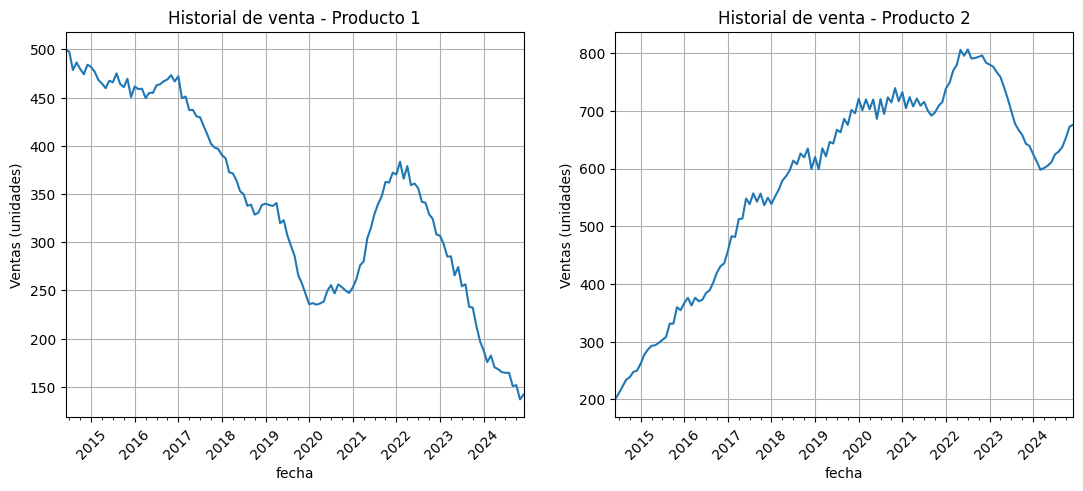

In [45]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
df["producto1"].plot()
plt.title("Historial de venta - Producto 1")
plt.ylabel("Ventas (unidades)")
plt.xticks(rotation=45)
plt.grid()

plt.subplot(1,2,2)
df["producto2"].plot()
plt.title("Historial de venta - Producto 2")
plt.ylabel("Ventas (unidades)")
plt.xticks(rotation=45)
plt.grid()

## Descomposición STL

In [32]:
# Descomposición STL de ambas series

stl_producto1 = STL(df["producto1"], seasonal=13)
stl_producto2 = STL(df["producto2"], seasonal=13)
result_producto1 = stl_producto1.fit()
result_producto2 = stl_producto2.fit()

df["producto1_trend"] = result_producto1.trend
df["producto1_seasonal"] = result_producto1.seasonal
df["producto2_trend"] = result_producto2.trend
df["producto2_seasonal"] = result_producto2.seasonal

# graficar usando plotly
graficar_serie_con_descomposicion(df, "producto #1", "producto1")
graficar_serie_con_descomposicion(df, "producto #2", "producto2")

- No se nota con claridad efectos estacionales.  
- Podemos notar una clara y marcada tendencia en ambas series de productos.

# Planeación

Para dar solución a lo solicitado, procederé con los siguientes pasos y aspectos a tener en cuenta para ambos productos:
- En primer lugar, realizar un analisis exploratorio de datos (EDA) para ganar contexto sobre las series de tiempo, además, descomponer las series en sus componentes de tendencia y estacionalidad para un analisis mas profundo.
- Se empleará una estrategia de selección de modelos jerarquica, dividida en 2 pasos. El primer paso será "validación" y por ultimo "prueba final".
- Para todo el proceso de ajuste y selección de modelos, usaré solo los ultimos 6 años de los datos (desde 2019-01-01 a 2024-12-01), dado que, las series presentan cambios a lo largo del tiempo y es mas representativa la ultima parte de la serie de tiempo.
- Para el calculo de metricas y evaluación de modelos, usaré una ventana movil con calculos mes a mes, dado que, en la practica asi desea hacer las predicciones el cliente. Además, este protocolo de evaluación ayuda a evitar el overfitting lo cual puede afectar la selección de los modelos.
- Para el paso de validación de modelos se usará la data hasta el 2024-06-01, dejando los ultimos 6 meses por fuera de los modelos como data para evaluar el desempeño ("out-of-sample"). Para el paso de prueba final se usará los ultimos 6 años completos, hasta el 2024-12-01, tambien dejando los ultimos 6 meses para evaluar.
-  En el paso de validación se filtrarán los 10 mejores modelos obtenidos en base a la metrica RMSE, uno por cada tipo de modelo de predicción y el resto hasta los 10 en base a su desempeño. para la prueba final, se calculará la metrica RMSE, MAPE y R2 por cada uno de los mejores modelos sobre la data "out-of-sample".
- En ambos pasos, los mejores modelos serán aquellos que minimicen el RMSE y el MAPE, y aquellos que maximicen el R2 sobre la data "out-of-sample".
- Se usarán estrategias de optimización para identificar las mejores combinaciones de hiperparametros para los modelos, tales como, gridsearch y optuna.
- Las familias de modelos y estrategias de optimización que se emplearán son: Modelos de suavización exponencial (Optuna), modelos ARIMA (gridsearch y validación de supuestos), Promedio movil (de 2 a 12), Regresión lineal multiple con estacionalidad de 12 meses (Grado 1 a grado 7, y validación de supuestos), Prophet (Optuna).

En el caso de los modelos ARIMA y RLM, para poder hacer uso del modelo y los pronósticos se deben cumplir los supuestos del Teorema de Gauss-Markov sobre los residuales.

- Probar **Autocorrelación** en los **residuales** con las pruebas Box-Pierce y Ljung-Box para los diferentes rezagos.

- Probar **Homoscedasticidad/Heteroscedasticidad** sobre los residuales, una aproximación para determinar si existe un comportamiento GARCH o ARCH es emplear la prueba de Ljung-Box sobre la serie (sin media) al cuadrado.

- Probar **Normalidad** sobre los residuales con las pruebas Jarque Bera y Shapiro-Wilk.

# Preparación de la data (FE)

In [33]:
# Data para paso de evaluación - desde 6 años atras hasta 6 meses antes del final
df_evaluacion = df.iloc[-1*(6*12):-6, 0:2].copy()
df_producto1_evaluacion = df_evaluacion["producto1"].copy()
df_producto2_evaluacion = df_evaluacion["producto2"].copy()

# Data para paso de validación - desde 6 meses antes del final hasta 2 meses antes del final
df_validacion = df.iloc[-1*(6*12):-2, 0:2].copy()
df_producto1_validacion = df_validacion["producto1"].copy()
df_producto2_validacion = df_validacion["producto2"].copy()

# Data para paso de test - ultimos 2 meses
df_test = df.iloc[-2:, 0:2].copy()
df_producto1_test = df_test["producto1"].copy()
df_producto2_test = df_test["producto2"].copy()

In [34]:
print("Tamaño de data de evaluacion, validación y test:")
df_producto1_evaluacion.shape,df_producto2_evaluacion.shape, df_producto1_validacion.shape, df_producto2_validacion.shape, df_producto1_test.shape, df_producto2_test.shape

Tamaño de data de evaluacion, validación y test:


((66,), (66,), (70,), (70,), (2,), (2,))

# 1. Validación inicial de modelos

En esta primera etapa, realizaré un primer filtro de los mejores 10 modelos validos y utiles para los dos productos, realizando busqueda u optimización de los mejores parametros de los modelos.  
Además, realizaré validación de supuestos sobre el error, para modelos ARIMA y RLM implementados con el objetivo de filtrar aquellos validos.

## ETS models

### producto 1

In [35]:
# Inicializamos parametros para evaluación por ventana recursiva (expansiva)
test_init = "2024-01-01"
test_finish = "2024-06-01"
window_type = "rolling"
train_size = (12*5) # 5 años
test_size = 1
metric = "rmse"

# Optimizamos el modelo ETS usando Optuna
study, best_params, rmse_movil = optimizar_modelo_ets(
    df_producto1_evaluacion,
    test_init,
    test_finish,
    window_type,
    train_size,
    test_size,
    metric,
    opt_trial=500,
)

Mejor resultado: 3.2494690619931474 con parámetros: {'trend': 'mul', 'seasonal': 'mul', 'use_box_cox': True, 'smoothing_level': 0.612, 'smoothing_trend': 0.784, 'damped_trend': False, 'seasonal_periods': 9, 'smoothing_seasonal': 0.032}


In [36]:
ets_prod1_results = study.trials_dataframe()
ets_prod1_results.sort_values(by="value", ascending=True, inplace=True)
ets_prod1_results = ets_prod1_results[
    [
        "value",
        "params_trend",
        "params_seasonal",
        "params_seasonal_periods",
        "params_damped_trend",
        "params_use_box_cox",
        "params_smoothing_level",
        "params_smoothing_trend",
        "params_smoothing_seasonal",
        "params_damping_trend",
    ]
]
ets_prod1_results.columns = (
    "rmse",
    "trend",
    "seasonal",
    "seasonal_periods",
    "damped_trend",
    "boxcox",
    "alpha",
    "beta",
    "gamma",
    "damping_trend",
)
ets_prod1_results.head(25)

,rmse,trend,seasonal,seasonal_periods,damped_trend,boxcox,alpha,beta,gamma,damping_trend
413,3.249469,mul,mul,9.0,False,True,0.612,0.784,0.032,NaN
497,3.267018,mul,mul,9.0,False,True,0.618,0.782,0.029,NaN
406,3.278944,mul,mul,9.0,False,True,0.600,0.797,0.040,NaN
499,3.288971,mul,mul,9.0,False,True,0.618,0.809,0.056,NaN
461,3.316796,mul,mul,9.0,False,True,0.643,0.771,0.067,NaN
449,3.334598,mul,mul,9.0,False,True,0.626,0.775,0.020,NaN
403,3.336883,mul,mul,9.0,False,True,0.607,0.784,0.026,NaN
446,3.345295,mul,mul,9.0,False,True,0.641,0.789,0.059,NaN
463,3.396453,mul,mul,9.0,False,True,0.622,0.828,0.064,NaN
256,3.417545,mul,add,9.0,False,True,0.615,0.579,0.027,NaN


### producto 2

In [37]:
# Inicializamos parametros para evaluación por ventana recursiva (expansiva)
test_init = "2024-01-01"
test_finish = "2024-06-01"
window_type = "rolling"
train_size = (12*5) # 5 años
test_size = 1
metric = "rmse"

# Optimizamos el modelo ETS usando Optuna
study, best_params, rmse_movil = optimizar_modelo_ets(
    df_producto2_evaluacion,
    test_init,
    test_finish,
    window_type,
    train_size,
    test_size,
    metric,
    opt_trial=500,
)


Mejor resultado: 5.91771714204292 con parámetros: {'trend': 'add', 'seasonal': None, 'use_box_cox': False, 'smoothing_level': 0.9480000000000001, 'smoothing_trend': 1.0, 'damped_trend': False}


In [38]:
ets_prod2_results = study.trials_dataframe()
ets_prod2_results.sort_values(by="value", ascending=True, inplace=True)
ets_prod2_results = ets_prod2_results[
    [
        "value",
        "params_trend",
        "params_seasonal",
        "params_seasonal_periods",
        "params_damped_trend",
        "params_use_box_cox",
        "params_smoothing_level",
        "params_smoothing_trend",
        "params_smoothing_seasonal",
        "params_damping_trend",
    ]
]
ets_prod2_results.columns = (
    "rmse",
    "trend",
    "seasonal",
    "seasonal_periods",
    "damped_trend",
    "boxcox",
    "alpha",
    "beta",
    "gamma",
    "damping_trend",
)
ets_prod2_results.head(25)

,rmse,trend,seasonal,seasonal_periods,damped_trend,boxcox,alpha,beta,gamma,damping_trend
300,5.917717,add,None,NaN,False,False,0.948,1.000,NaN,NaN
294,5.920279,add,None,NaN,False,False,0.949,1.000,NaN,NaN
231,5.920731,add,None,NaN,False,False,0.948,0.999,NaN,NaN
457,5.924661,add,None,NaN,False,False,0.950,1.000,NaN,NaN
185,5.929125,add,None,NaN,False,False,0.951,1.000,NaN,NaN
453,5.929261,add,None,NaN,False,False,0.946,1.000,NaN,NaN
123,5.929942,mul,None,NaN,False,True,0.955,1.000,NaN,NaN
483,5.938294,add,None,NaN,False,False,0.953,1.000,NaN,NaN
308,5.938294,add,None,NaN,False,False,0.953,1.000,NaN,NaN
395,5.938649,add,None,NaN,False,False,0.953,0.984,NaN,NaN


## ARIMA models

### Producto 1

In [39]:
# Funcion para ajustar modelos ARIMA con evaluación por ventana
arima_prod1_results = ajustar_modelos_arima(
    df=df_producto1_evaluacion,
    test_init="2024-01-01",
    test_finish="2024-06-01",
    p_range=range(0,8),
    d_range=range(0,3),
    q_range=range(0,8),
)

# Función para validar supuestos de ARIMA
arima_prod1_results = validar_supuestos_df(df_producto1_evaluacion, arima_prod1_results, "ARIMA", alpha=0.05)
arima_prod1_results = arima_prod1_results[arima_prod1_results["CumpleSupuestos"] == True].drop(columns=["CumpleSupuestos"]).sort_values(by="RMSE", ascending=True)
arima_prod1_results.head(25)

,Modelo,RMSE
0,"ARIMA(2,1,1)",5.403248
1,"ARIMA(0,1,4)",5.528470
2,"ARIMA(1,1,3)",5.593925
3,"ARIMA(3,1,0)",5.658150
4,"ARIMA(5,0,3)",5.769227
5,"ARIMA(0,1,5)",5.782504
7,"ARIMA(1,0,5)",6.028258
8,"ARIMA(3,1,1)",6.057348
10,"ARIMA(4,1,0)",6.148954
11,"ARIMA(2,0,5)",6.230033


### Producto 2

In [40]:
# Funcion para ajustar modelos ARIMA con evaluación por ventana
arima_prod2_results = ajustar_modelos_arima(
    df=df_producto2_evaluacion,
    test_init="2024-01-01",
    test_finish="2024-06-01",
    p_range=range(0,8),
    d_range=range(0,3),
    q_range=range(0,8),
)

arima_prod2_results = validar_supuestos_df(df_producto2_evaluacion, arima_prod2_results, "ARIMA", alpha=0.05)
arima_prod2_results = arima_prod2_results[arima_prod2_results["CumpleSupuestos"] == True].drop(columns=["CumpleSupuestos"]).sort_values(by="RMSE", ascending=True)
arima_prod2_results.head(25)

,Modelo,RMSE
0,"ARIMA(4,0,7)",5.651181
1,"ARIMA(4,1,3)",6.019994
3,"ARIMA(2,0,6)",6.261721
4,"ARIMA(5,1,3)",6.343040
5,"ARIMA(4,0,4)",6.404755
6,"ARIMA(1,1,6)",6.499476
7,"ARIMA(7,0,3)",6.522055
8,"ARIMA(7,1,7)",6.597428
9,"ARIMA(3,0,7)",6.601378
10,"ARIMA(3,0,5)",6.747738


## Mean Average models

### Producto 1

In [41]:
ma_prod1_results = pd.DataFrame(columns=["size", "rmse"])

# Evaluamos el modelo MA para diferentes tamaños de ventana 
for size in range(2,12):
    fit_params = {"window_size":size, "horizon":1}

    metric = evalua_modelo_ST_por_ventana(
        index_name="fecha",
        model_type="MA",
        init_params={},
        fit_params=fit_params,
        data=df_producto1_evaluacion,
        test_init="2024-01-01",
        test_finish="2024-06-01",
        window_type="rolling",
        train_size=12 * 5,  # 5 años
        test_size=1,
        metric="rmse",
    )

    result = pd.DataFrame(
        {
            "size": size,
            "rmse": metric,
        }, index=[0]
    )

    ma_prod1_results = pd.concat([ma_prod1_results, result], ignore_index=True)

ma_prod1_results.sort_values(by="rmse", ascending=True, inplace=True)
ma_prod1_results

,size,rmse
0,2,10.420271
1,3,14.866673
2,4,20.109563
3,5,25.998089
4,6,31.818656
5,7,37.720047
6,8,42.982328
7,9,48.234848
8,10,53.012563
9,11,57.719479


### Producto 2

In [42]:
ma_prod2_results = pd.DataFrame(columns=["size", "rmse"])

# Evaluamos el modelo MA para diferentes tamaños de ventana 
for size in range(2,12):
    fit_params = {"window_size":size, "horizon":1}

    metric = evalua_modelo_ST_por_ventana(
        index_name="fecha",
        model_type="MA",
        init_params={},
        fit_params=fit_params,
        data=df_producto2_evaluacion,
        test_init="2024-01-01",
        test_finish="2024-06-01",
        window_type="rolling",
        train_size=12 * 5,  # 5 años
        test_size=1,
        metric="rmse",
    )

    result = pd.DataFrame(
        {
            "size": size,
            "rmse": metric,
        }, index=[0]
    )

    ma_prod2_results = pd.concat([ma_prod2_results, result], ignore_index=True)

ma_prod2_results.sort_values(by="rmse", ascending=True, inplace=True)
ma_prod2_results

,size,rmse
0,2,13.202259
1,3,16.939000
2,4,21.870462
3,5,27.260600
4,6,32.857416
5,7,39.090412
6,8,45.827204
7,9,53.106736
8,10,60.707997
9,11,68.333520


## RLM models

### Producto 1

In [43]:
rlm_prod1_results = []

for grado in range(1, 8):  # Grados de 1 a 7
    for seasonal in [True, False]:
        init_params = {
            "degree": grado,
            "seasonal": seasonal,
        }

        metrica = evalua_modelo_ST_por_ventana(
            index_name="fecha",
            model_type="RLM",
            init_params=init_params,
            fit_params={},
            data=df_producto1_evaluacion,
            test_init="2024-01-01",
            test_finish="2024-06-01",
            window_type="rolling",
            train_size=12 * 5,  # 5 años
            test_size=1,
            metric="rmse",
        )
        rlm_prod1_results.append({"grado": grado, "seasonal": seasonal, "rmse": metrica})

rlm_prod1_results = pd.DataFrame(rlm_prod1_results).sort_values(by="rmse", ascending=True)

rlm_prod1_results = validar_supuestos_df(df_producto1_evaluacion, rlm_prod1_results, "RLM", alpha=0.05)
rlm_prod1_results

,grado,seasonal,rmse,CumpleSupuestos
11,6,False,11.872740,False
10,6,True,12.040952,False
7,4,False,17.029482,False
12,7,True,25.084749,False
9,5,False,26.714110,False
13,7,False,27.087129,False
6,4,True,28.120763,False
8,5,True,28.228048,False
3,2,False,50.590560,False
5,3,False,65.671099,False


### Producto 2

In [44]:
rlm_prod2_results = []

for grado in range(1, 8):  # Grados de 1 a 7
    for seasonal in [True, False]:
        init_params = {
            "degree": grado,
            "seasonal": seasonal,
        }

        metrica = evalua_modelo_ST_por_ventana(
            index_name="fecha",
            model_type="RLM",
            init_params=init_params,
            fit_params={},
            data=df_producto2_evaluacion,
            test_init="2024-01-01",
            test_finish="2024-06-01",
            window_type="rolling",
            train_size=12 * 5,  # 5 años
            test_size=1,
            metric="rmse",
        )
        rlm_prod2_results.append({"grado": grado, "seasonal": seasonal, "rmse": metrica})

rlm_prod2_results = pd.DataFrame(rlm_prod2_results).sort_values(by="rmse", ascending=True)

rlm_prod2_results = validar_supuestos_df(df_producto2_evaluacion, rlm_prod2_results, "RLM", alpha=0.05)
rlm_prod2_results

,grado,seasonal,rmse,CumpleSupuestos
5,3,False,20.935383,False
11,6,False,21.211103,False
10,6,True,23.323924,False
4,3,True,25.021186,False
8,5,True,33.280561,False
13,7,False,34.333160,False
12,7,True,39.413856,False
9,5,False,42.458444,False
3,2,False,49.948314,False
2,2,True,61.458688,False


**Observación:**  
Ningún modelo de tipo RLM cumplió los supuestos sobre el error al ajustarlo con toda la data de evaluación.

## Prophet

### Producto 1

In [ ]:
# Inicializamos parametros para evaluación por ventana recursiva (expansiva)
test_init = "2024-01-01"
test_finish = "2024-06-01"
window_type = "rolling"
train_size = (12*5) # 5 años
test_size = 1
metric = "rmse"

# Optimizamos el modelo ETS usando Optuna
study, best_params, rmse_movil = optimizar_modelo_prophet(
    df_producto1_evaluacion,
    test_init,
    test_finish,
    window_type,
    train_size,
    test_size,
    metric,
    opt_trial=300,
)

Mejor resultado: 4.616283493064674 con parámetros: {'changepoint_prior_scale': 0.13627837558697797, 'seasonality_prior_scale': 0.16239529852733586, 'seasonality_mode': 'multiplicative', 'n_changepoints': 3, 'yearly_seasonality': 20}


In [ ]:
prophet_prod1_results = study.trials_dataframe()
prophet_prod1_results.sort_values(by="value", ascending=True, inplace=True)
prophet_prod1_results = prophet_prod1_results[
    [
        "value",
        "params_changepoint_prior_scale",
        "params_n_changepoints",
        "params_seasonality_mode",
        "params_seasonality_prior_scale",
        "params_yearly_seasonality",
    ]
]
prophet_prod1_results.columns = (
    "rmse",
    "changepoint_prior_scale",
    "n_changepoints",
    "seasonality_mode",
    "seasonality_prior_scale",
    "yearly_seasonality",
)
prophet_prod1_results.head(25)

,rmse,changepoint_prior_scale,n_changepoints,seasonality_mode,seasonality_prior_scale,yearly_seasonality
288,4.616283,0.136278,3,multiplicative,0.162395,20
251,4.638286,0.093444,3,multiplicative,0.162642,20
219,4.654286,0.147755,3,multiplicative,0.122273,20
253,4.675086,0.109232,3,multiplicative,0.141332,20
241,4.702270,0.136831,3,multiplicative,0.116280,20
222,4.709328,0.154295,3,multiplicative,0.123488,20
233,4.721666,0.114665,3,multiplicative,0.145537,19
249,4.741597,0.107160,3,multiplicative,0.138027,20
246,4.742180,0.112552,3,multiplicative,0.142279,19
217,4.742397,0.159188,3,multiplicative,0.100851,20


### Producto 2

In [18]:
# Inicializamos parametros para evaluación por ventana recursiva (expansiva)
test_init = "2024-01-01"
test_finish = "2024-06-01"
window_type = "rolling"
train_size = (12*5) # 5 años
test_size = 1
metric = "rmse"

# Optimizamos el modelo ETS usando Optuna
study, best_params, rmse_movil = optimizar_modelo_prophet(
    df_producto2_evaluacion,
    test_init,
    test_finish,
    window_type,
    train_size,
    test_size,
    metric,
    opt_trial=300,
)

Mejor resultado: 6.7273868719654955 con parámetros: {'changepoint_prior_scale': 0.06379193869258602, 'seasonality_prior_scale': 0.05359522974233927, 'seasonality_mode': 'multiplicative', 'n_changepoints': 8, 'yearly_seasonality': 14}


In [19]:
prophet_prod2_results = study.trials_dataframe()
prophet_prod2_results.sort_values(by="value", ascending=True, inplace=True)
prophet_prod2_results = prophet_prod2_results[
    [
        "value",
        "params_changepoint_prior_scale",
        "params_n_changepoints",
        "params_seasonality_mode",
        "params_seasonality_prior_scale",
        "params_yearly_seasonality",
    ]
]
prophet_prod2_results.columns = (
    "rmse",
    "changepoint_prior_scale",
    "n_changepoints",
    "seasonality_mode",
    "seasonality_prior_scale",
    "yearly_seasonality",
)
prophet_prod2_results.head(25)

,rmse,changepoint_prior_scale,n_changepoints,seasonality_mode,seasonality_prior_scale,yearly_seasonality
247,6.727387,0.063792,8,multiplicative,0.053595,14
259,7.050331,0.054846,8,multiplicative,0.085506,15
16,7.307064,0.090060,8,multiplicative,0.157284,15
291,7.317786,0.057139,8,multiplicative,0.111152,15
266,7.455621,0.061443,8,multiplicative,0.076599,16
253,7.520178,0.053764,8,multiplicative,0.081555,17
293,7.520429,0.050121,8,multiplicative,0.112572,15
271,7.642016,0.049808,8,multiplicative,0.077416,16
270,7.646424,0.055785,8,multiplicative,0.080656,16
274,7.691785,0.049273,8,multiplicative,0.070123,16


# 2. Test final de modelos

## Producto 1

## Producto 2

In [ ]:
# Entrenar el mejor modelo

In [19]:
# # creamos el diccionario de parametros para inicializar el modelo ETS
#         init_params = {
#             "trend": trend,
#             "damped_trend": damped_trend,
#             "seasonal": seasonal,
#             "seasonal_periods": seasonal_periods,
#             "use_boxcox": use_box_cox,
#         }

#         # Creamos el diccionario de parametros para ajustar el modelo ETS
#         fit_params = {
#             "smoothing_level": slevel,
#             "smoothing_trend": strend,
#             "smoothing_seasonal": sseasonal,
#             "damping_trend": damping_value,
#         }
